# IPL Dataset Analysis
This notebook implements the analysis requirements for the Cricket Performance and Insights System.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Data Ingestion & Cleaning

In [2]:
# Load datasets
matches = pd.read_csv("C:/Users/Govind/Downloads/matches.csv")
deliveries = pd.read_csv("C:/Users/Govind/Downloads/deliveries.csv")

# Convert date to datetime
matches['date'] = pd.to_datetime(matches['date'], errors='coerce')
matches['year'] = matches['date'].dt.year
matches['month'] = matches['date'].dt.month_name()

# Merge datasets
merged_data = deliveries.merge(matches, left_on='match_id', right_on='id', how='left')

print(f'Matches shape: {matches.shape}')
print(f'Deliveries shape: {deliveries.shape}')
print(f'Merged shape: {merged_data.shape}')

Matches shape: (1095, 22)
Deliveries shape: (260920, 17)
Merged shape: (260920, 39)


## 5.1 Player Performance Analysis

FR1: Top Scoring Batsmen Post-2020 (Excluding Veterans)
batter
Shubman Gill    2277
RD Gaikwad      2176
KL Rahul        2036
JC Buttler      1868
SV Samson       1835
YBK Jaiswal     1567
Ishan Kishan    1433
S Dube          1333
VR Iyer         1326
N Pooran        1248
Name: batsman_runs, dtype: int64


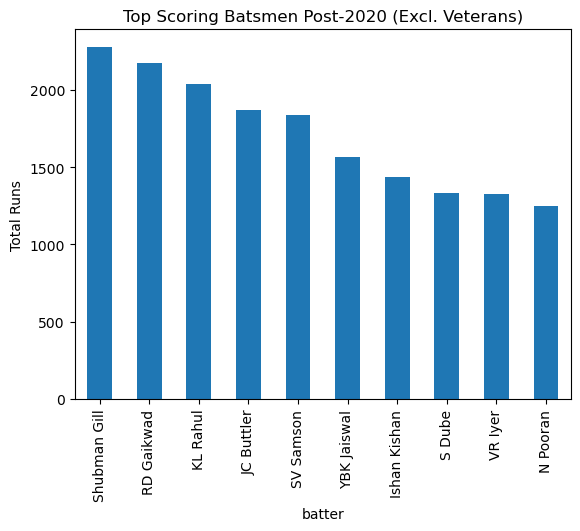

In [3]:
# Helper: Identify players active in 2008-2012
early_seasons = matches[matches['year'].between(2008, 2012)]['id'].unique()
early_players_bat = deliveries[deliveries['match_id'].isin(early_seasons)]['batter'].unique()
early_players_bowl = deliveries[deliveries['match_id'].isin(early_seasons)]['bowler'].unique()

# FR1: Top-scoring batsmen post-2020 (excluding 2008-2012 veterans)
post_2020_matches = matches[matches['year'] > 2020]['id'].unique()
post_2020_data = deliveries[deliveries['match_id'].isin(post_2020_matches)]

fr1_data = post_2020_data[~post_2020_data['batter'].isin(early_players_bat)]
top_scorers = fr1_data.groupby('batter')['batsman_runs'].sum().sort_values(ascending=False).head(10)

print('FR1: Top Scoring Batsmen Post-2020 (Excluding Veterans)')
print(top_scorers)

plt.figure()
top_scorers.plot(kind='bar', title='Top Scoring Batsmen Post-2020 (Excl. Veterans)')
plt.ylabel('Total Runs')
plt.show()

In [21]:
# FR2: Power hitters with highest strike rate (>= 50 balls faced) post-2020
stats = post_2020_data.groupby('batter').agg({'batsman_runs': 'sum', 'ball': 'count'})
stats = stats[stats['ball'] >= 50]
stats['strike_rate'] = (stats['batsman_runs'] / stats['ball']) * 100
top_sr = stats.sort_values('strike_rate', ascending=False).head(10)

print('\nFR2: Top Power Hitters Post-2020 (Strike Rate)')
print(top_sr[['strike_rate', 'ball', 'batsman_runs']])



FR2: Top Power Hitters Post-2020 (Strike Rate)
                 strike_rate  ball  batsman_runs
batter                                          
J Fraser-McGurk   220.000000   150           330
TM Head           184.690554   307           567
WG Jacks          172.932331   133           230
PD Salt           169.610390   385           653
T Stubbs          169.456067   239           405
R Shepherd        169.117647    68           115
H Klaasen         167.027027   555           927
Naman Dhir        166.666667    84           140
Ramandeep Singh   160.377358   106           170
Ashutosh Sharma   160.169492   118           189



FR3: Top Fielders by Catches (All Time)
MS Dhoni          152
KD Karthik        145
AB de Villiers    120
V Kohli           114
SK Raina          106
S Dhawan          100
RG Sharma         100
RA Jadeja          97
KA Pollard         97
WP Saha            93
Name: fielder, dtype: int64


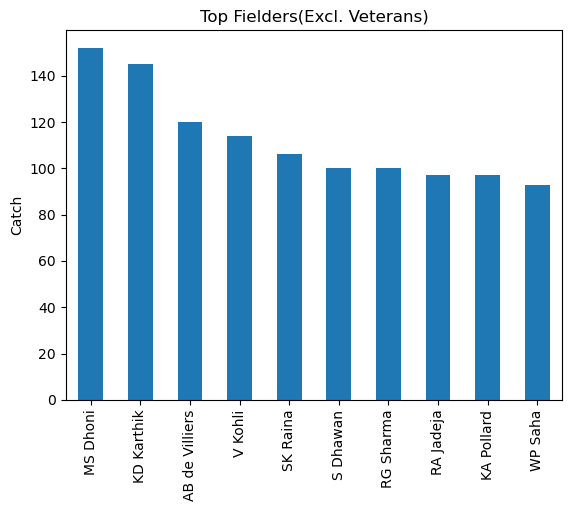

In [17]:
# FR3: Top fielders by number of catches (All time)
catches = deliveries[deliveries['dismissal_kind'] == 'caught']
top_fielders = catches['fielder'].value_counts().head(10)

print('\nFR3: Top Fielders by Catches (All Time)')
print(top_fielders)
plt.figure()
top_fielders.plot(kind='bar', title='Top Fielders(Excl. Veterans)')
plt.ylabel('Catch')
plt.show()


FR4: Top Bowlers Post-2020 (Excluding Veterans)
YS Chahal         84
Rashid Khan       74
Avesh Khan        70
Mohammed Shami    67
CV Varun          65
Arshdeep Singh    64
TA Boult          58
JJ Bumrah         56
K Rabada          56
Mohammed Siraj    54
Name: bowler, dtype: int64


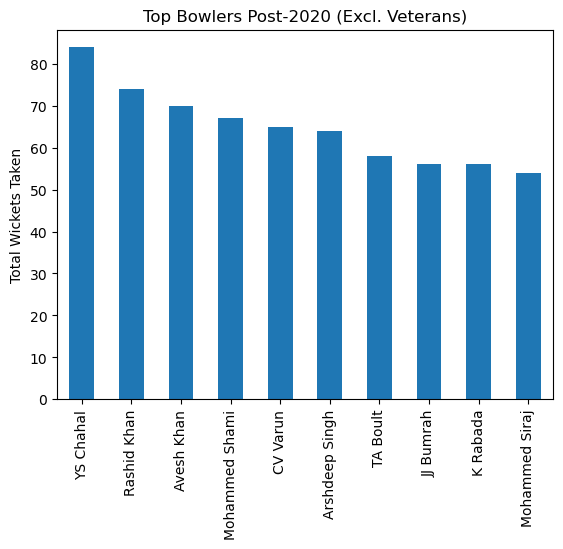

In [15]:
# FR4: Top bowlers by wickets post-2020 (excluding 2008-2012 veterans)
fr4_data = post_2020_data[~post_2020_data['bowler'].isin(early_players_bowl)]
wickets = fr4_data[fr4_data['is_wicket'] == 1]
# Exclude run outs for bowler stats
wickets = wickets[~wickets['dismissal_kind'].isin(['run out', 'retired hurt', 'obstructing the field'])]

top_bowlers = wickets['bowler'].value_counts().head(10)

print('\nFR4: Top Bowlers Post-2020 (Excluding Veterans)')
print(top_bowlers)
plt.figure()
top_bowlers.plot(kind='bar', title='Top Bowlers Post-2020 (Excl. Veterans)')
plt.ylabel('Total Wickets Taken')
plt.show()

## 5.2 Stadium and Match Outcome Analysis

In [7]:
# Helper for stadium analysis
def calculate_win_prob(df, win_condition):
    total = df.groupby('venue')['id'].count()
    wins = df[win_condition].groupby('venue')['id'].count()
    prob = (wins / total * 100).fillna(0)
    return prob

# FR5: Batting First Win Probability per Stadium
# Assuming 'result' != 'tie' or 'no result' for simplicity, or just raw counts
# Logic: if toss_decision == 'bat' and toss_winner == winner -> Bat 1st Won
# OR if toss_decision == 'field' and toss_winner != winner -> Bat 1st Won

def bat_first_won(row):
    if row['result'] == 'tie' or row['result'] == 'no result':
        return False
    if row['toss_decision'] == 'bat':
        return row['toss_winner'] == row['winner']
    else: # field
        return row['toss_winner'] != row['winner']

matches['bat_first_win'] = matches.apply(bat_first_won, axis=1)
matches['field_first_win'] = ~matches['bat_first_win'] & (matches['result'] != 'tie') & (matches['result'] != 'no result')

fr5 = calculate_win_prob(matches, matches['bat_first_win'])
print('\nFR5: Batting First Win Probability per Stadium')
print(fr5.sort_values(ascending=False).head(10))

# FR7: Fielding First Win Probability per Stadium
fr7 = calculate_win_prob(matches, matches['field_first_win'])
print('\nFR7: Fielding First Win Probability per Stadium')
print(fr7.sort_values(ascending=False).head(10))


FR5: Batting First Win Probability per Stadium
venue
Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam    100.000000
Maharashtra Cricket Association Stadium, Pune                          76.923077
Himachal Pradesh Cricket Association Stadium, Dharamsala               75.000000
Barsapara Cricket Stadium, Guwahati                                    66.666667
Buffalo Park                                                           66.666667
Vidarbha Cricket Association Stadium, Jamtha                           66.666667
MA Chidambaram Stadium, Chepauk                                        62.500000
Subrata Roy Sahara Stadium                                             62.500000
Brabourne Stadium                                                      60.000000
Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh       60.000000
Name: id, dtype: float64

FR7: Fielding First Win Probability per Stadium
venue
Green Park                                          100.

In [8]:
# FR6 & FR8: Month-wise analysis
stadium_month_stats = matches.groupby(['venue', 'month']).agg(
    total_matches=('id', 'count'),
    bat_first_wins=('bat_first_win', 'sum'),
    field_first_wins=('field_first_win', 'sum')
)

stadium_month_stats['bat_first_prob'] = (stadium_month_stats['bat_first_wins'] / stadium_month_stats['total_matches']) * 100
stadium_month_stats['field_first_prob'] = (stadium_month_stats['field_first_wins'] / stadium_month_stats['total_matches']) * 100

print('\nFR6 & FR8: Stadium-Month Win Probabilities (Sample)')
print(stadium_month_stats.head(10))


FR6 & FR8: Stadium-Month Win Probabilities (Sample)
                                           total_matches  bat_first_wins  \
venue                               month                                  
Arun Jaitley Stadium                April              6               4   
                                    March              2               0   
                                    May                6               3   
Arun Jaitley Stadium, Delhi         April              9               4   
                                    May                7               5   
Barabati Stadium                    April              1               0   
                                    March              2               2   
                                    May                4               2   
Barsapara Cricket Stadium, Guwahati April              2               2   
                                    May                1               0   

                                  

## 5.3 Coaching Candidate Identification

In [11]:
# Helper: Find coaching candidates
# Criteria: Good performance in last active season, inactive for last 2 seasons (2024, 2025)
# Assuming dataset goes up to 2025. If not, we adjust logic. 
# Let's assume 'current' is 2025. Inactive means last played <= 2023.

all_player_seasons = merged_data.groupby('batter')['year'].max().reset_index()
all_player_seasons.columns = ['player', 'last_season']

# Filter for inactive players (Last season <= 2023)
inactive_players = all_player_seasons[all_player_seasons['last_season'] <= 2023]

def get_last_season_performance(player_list, metric_col, agg_func, top_n=10):
    candidates = []
    for player in player_list['player']:
        last_yr = player_list[player_list['player'] == player]['last_season'].values[0]
        # Get data for that player in that season
        player_data = merged_data[(merged_data['year'] == last_yr) & 
                                  ((merged_data['batter'] == player) | (merged_data['bowler'] == player) | (merged_data['fielder'] == player))]
        
        if player_data.empty: continue
            
        # Calculate metric
        if metric_col == 'batsman_runs':
            val = player_data[player_data['batter'] == player]['batsman_runs'].sum()
        elif metric_col == 'is_wicket':
            val = player_data[(player_data['bowler'] == player) & (player_data['is_wicket'] == 1)]['is_wicket'].count()
        elif metric_col == 'catch':
            val = player_data[(player_data['fielder'] == player) & (player_data['dismissal_kind'] == 'caught')].shape[0]
            
        candidates.append({'player': player, 'last_season': last_yr, 'metric': val})
    
    return pd.DataFrame(candidates).sort_values('metric', ascending=False).head(top_n)

# FR9: Batting Coach Candidates
batting_candidates = get_last_season_performance(inactive_players, 'batsman_runs', 'sum')
print('\nFR9: Potential Batting Coach Candidates')
print(batting_candidates)

# FR10: Bowling Coach Candidates
# Need to get bowlers list first
all_bowler_seasons = merged_data.groupby('bowler')['year'].max().reset_index()
all_bowler_seasons.columns = ['player', 'last_season']
inactive_bowlers = all_bowler_seasons[all_bowler_seasons['last_season'] <= 2022]

bowling_candidates = get_last_season_performance(inactive_bowlers, 'is_wicket', 'count')
print('\nFR10: Potential Bowling Coach Candidates')
print(bowling_candidates)

# FR11: Fielding Coach Candidates
all_fielder_seasons = merged_data.groupby('fielder')['year'].max().reset_index()
all_fielder_seasons.columns = ['player', 'last_season']
inactive_fielders = all_fielder_seasons[all_fielder_seasons['last_season'] <= 2022]

fielding_candidates = get_last_season_performance(inactive_fielders, 'catch', 'count')
print('\nFR11: Potential Fielding Coach Candidates')
print(fielding_candidates)


FR9: Potential Batting Coach Candidates
               player  last_season  metric
132         DP Conway         2023     672
350          R Dravid         2013     471
169           HM Amla         2017     420
234         KR Mayers         2023     379
330          PA Patel         2019     373
286         ML Hayden         2010     346
135  DPMD Jayawardene         2013     331
24     AB de Villiers         2021     313
427         SR Watson         2020     299
26       AC Gilchrist         2013     294

FR10: Potential Bowling Coach Candidates
                player  last_season  metric
313      Sohail Tanvir         2008      24
182  M Prasidh Krishna         2022      21
5             A Kumble         2010      19
288         SL Malinga         2019      18
67           CH Morris         2021      17
86            DJ Bravo         2022      17
97             DR Sams         2022      14
108         GD McGrath         2008      14
287           SK Warne         2011      14
324 